In [1]:
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 設定 Matplotlib 使用中文字體
font_path = 'C:/Users/gary8/實價登錄之應用/NotoSansTC-Medium.ttf'
font_prop = FontProperties(fname = font_path, size = 18)
plt.rcParams['font.family'] = font_prop.get_name()
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft JhengHei']})

In [2]:
### 1.資料夾整理 ###
'''
匯入從實價登錄網站所爬取的各年份資料夾
'''
# 列出所有資料夾
folders = [d for d in os.listdir() if os.path.isdir(os.path.join(d)) and d[0] == '1']
print('所有資料夾:\n',folders)

# 刪除 101 年資料夾
'''
101 年資料夾有重大缺失不夠完善，予以刪除
'''
folders = [d for d in folders if d not in ['101S1', '101S2', '101S3','101S4']]
print('\n102年之後的資料夾:\n',folders)

所有資料夾:
 ['101S1', '101S2', '101S3', '101S4', '102S1', '102S2', '102S3', '102S4', '103S1', '103S2', '103S3', '103S4', '104S1', '104S2', '104S3', '104S4', '105S1', '105S2', '105S3', '105S4', '106S1', '106S2', '106S3', '106S4', '107S1', '107S2', '107S3', '107S4', '108S1', '108S2', '108S3', '108S4', '109S1', '109S2', '109S3', '109S4', '110S1', '110S2', '110S3', '110S4', '111S1', '111S2', '111S3', '111S4', '112S1', '112S2', '112S3']

102年之後的資料夾:
 ['102S1', '102S2', '102S3', '102S4', '103S1', '103S2', '103S3', '103S4', '104S1', '104S2', '104S3', '104S4', '105S1', '105S2', '105S3', '105S4', '106S1', '106S2', '106S3', '106S4', '107S1', '107S2', '107S3', '107S4', '108S1', '108S2', '108S3', '108S4', '109S1', '109S2', '109S3', '109S4', '110S1', '110S2', '110S3', '110S4', '111S1', '111S2', '111S3', '111S4', '112S1', '112S2', '112S3']


In [3]:
### 2.資料匯入與整理 ###

dfs_rental = []

for d in folders:
    
    # 匯入各年台北市租屋 CSV 檔案
    df_rental_a = pd.read_csv(os.path.join(d,'A_lvr_land_C.csv'), index_col = False, quoting = csv.QUOTE_NONE)
    df_rental_a['季度'] = d[-1]
    df_rental_a['交易類型'] = "租屋"
    df_rental_a['縣市'] = '台北市'
    dfs_rental.append(df_rental_a.iloc[1:])
    
    # 匯入各年新北市租屋 CSV 檔案
    df_rental_f = pd.read_csv(os.path.join(d,'F_lvr_land_C.csv'), index_col = False, quoting = csv.QUOTE_NONE)
    df_rental_f['季度'] = d[-1]
    df_rental_f['交易類型'] = "租屋"
    df_rental_f['縣市'] = '新北市'
    dfs_rental.append(df_rental_f.iloc[1:])

# 整併雙北租屋資訊
df_rental = pd.concat(dfs_rental, sort = True)

# 新增資訊
df_rental['年份'] = df_rental['租賃年月日'].astype(str).str[:3].astype(int)
df_rental['單價元坪'] = df_rental['單價元平方公尺'].astype(float)* 3.305785
df_rental['總額元'] = df_rental['總額元'].astype(float)
df_rental['建物型態2'] = df_rental['建物型態'].str.split('(').str[0]

# 選擇欲租屋區域
'''
台北工作位於市中心居多，因此以市中心向外選擇幾個區域作為租屋考量
'''
regions = {'三重區', '中和區', '中山區', '中正區', '信義區', '內湖區', '北投區', '南港區', '士林區', '大同區', '大安區', '文山區',
           '新店區', '新莊區', '松山區', '板橋區', '永和區', '萬華區', '蘆洲區'}

In [4]:
### 3.了解市場行情 ###

## 3-1.查看今年價格敘述性統計 ##
'''
大致上租賃的房價最大值與 75 百分位數有一定差距，標準差也偏大，推測可能會有許多離群值。
以下 3-2 利用做圖來其分佈趨勢。
'''
cond = (  (df_rental['主要用途'] == '住家用')
        & (df_rental['年份'] == 112)
        & (df_rental['鄉鎮市區'].isin(regions))
       )
df_rental[cond].groupby('鄉鎮市區')['單價元坪'].describe()

,count,mean,std,min,25%,50%,75%,max
鄉鎮市區,,,,,,,,
三重區,682.0,1021.434246,430.125722,353.718995,717.355345,904.132198,1209.917310,3368.594915
中和區,703.0,963.657488,460.979483,238.016520,677.685925,852.892530,1110.743760,4426.446115
中山區,863.0,1705.723771,514.427680,499.173535,1335.537140,1676.032995,2026.446205,3361.983345
中正區,230.0,1543.456644,559.636882,585.123945,1175.206568,1452.892508,1811.570180,4667.768420
信義區,363.0,1552.198107,775.488001,466.115685,1044.628060,1391.735485,1933.884225,10072.726895
內湖區,392.0,1097.200161,406.357193,396.694200,833.057820,998.347070,1271.074333,2912.396585
北投區,396.0,1034.877664,361.978804,310.743790,790.082615,970.247898,1213.223095,2753.718905
南港區,153.0,1080.041012,381.351403,419.834695,799.999970,1047.933845,1305.785075,2234.710660
士林區,524.0,1389.401248,576.164753,502.479320,976.859468,1276.033010,1642.975145,4353.718845


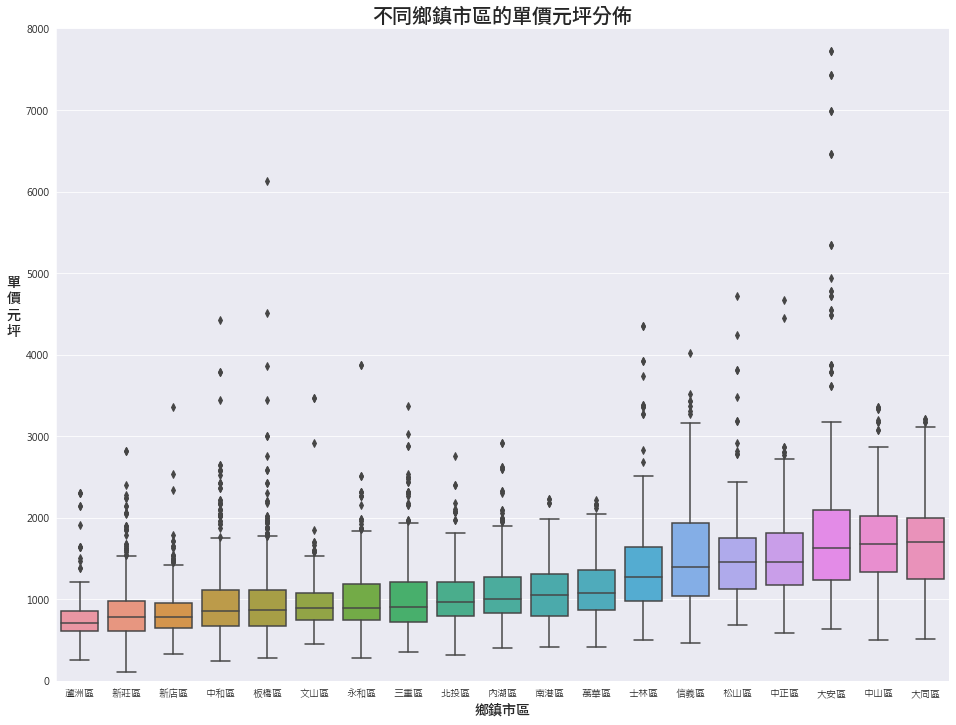

In [5]:
## 3-2.查看今年價格分佈 ##
'''
從圖明顯看出每一市區都有離群值的產生，因此以下傾向使用價格的中位數作為各市區比較的基準。
'''

# 按鄉鎮市區分组，並計算每組中位數，依中位數升冪排序。
median_prices_by_region = df_rental[cond].groupby('鄉鎮市區')['單價元坪'].median().sort_values(ascending = True)

plt.figure(figsize = (16, 12))
sns.boxplot(x = '鄉鎮市區', y = '單價元坪', data = df_rental[cond], order = median_prices_by_region.index) 
plt.ylim(0,8000)
plt.xlabel('鄉鎮市區', fontproperties = font_prop, fontsize = 14)
plt.ylabel('單     \n價     \n元     \n坪     \n', fontproperties = font_prop, rotation = 0, fontsize = 14)
plt.title('不同鄉鎮市區的單價元坪分佈', fontproperties = font_prop, fontsize = 20)
plt.show()

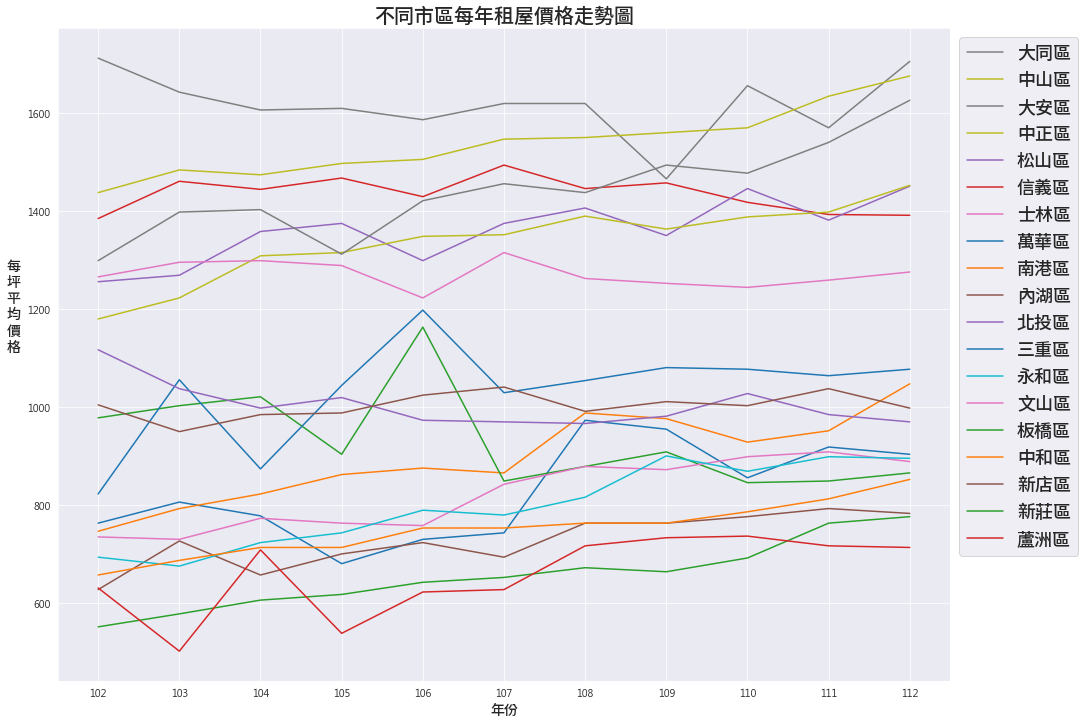

In [6]:
## 3.3不同市區每年租屋價格走勢圖 ##
'''
整體來說，漲幅並不明顯。但明顯價位分成兩個區段(每坪1200以上與每坪1100以下)。
在只考慮價格得情況之下，萬華區以下區域是考量重點。
'''
price_rental = {}

for district in regions:
    cond2 = (  (df_rental['主要用途'] == '住家用')
             & (df_rental['鄉鎮市區'] == district)
            )
    groups = df_rental[cond2]['年份']    
    price_rental[district] = df_rental[cond2]['單價元坪'].astype(float).groupby(groups).median().loc[102:112]
    
price_history_rental = pd.DataFrame(price_rental)

# 繪製資料
fig, ax = plt.subplots(figsize = (16, 12))
price_history_rental.plot(ax = ax)
plt.xlabel('年份', fontproperties = font_prop, fontsize = 14)
plt.ylabel('每      \n坪      \n平      \n均      \n價      \n格      ', fontproperties = font_prop, fontsize = 14, rotation = 0)
plt.title('不同市區每年租屋價格走勢圖', fontproperties = font_prop, fontsize = 20)

# 取得當前的圖例物件
handles, labels = plt.gca().get_legend_handles_labels()

# 按照 sorted_columns 的順序重新排列 handles 和 labels
sorted_columns = price_history_rental.loc[112].sort_values(ascending=False).index
handles = [handles[labels.index(column)] for column in sorted_columns]
labels = sorted_columns

# 更新圖例
plt.legend(handles, labels,loc = 'upper left', bbox_to_anchor = (1, 1), fontsize = 5, prop = font_prop)
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.xticks(ticks = price_history_rental.index)

plt.show()


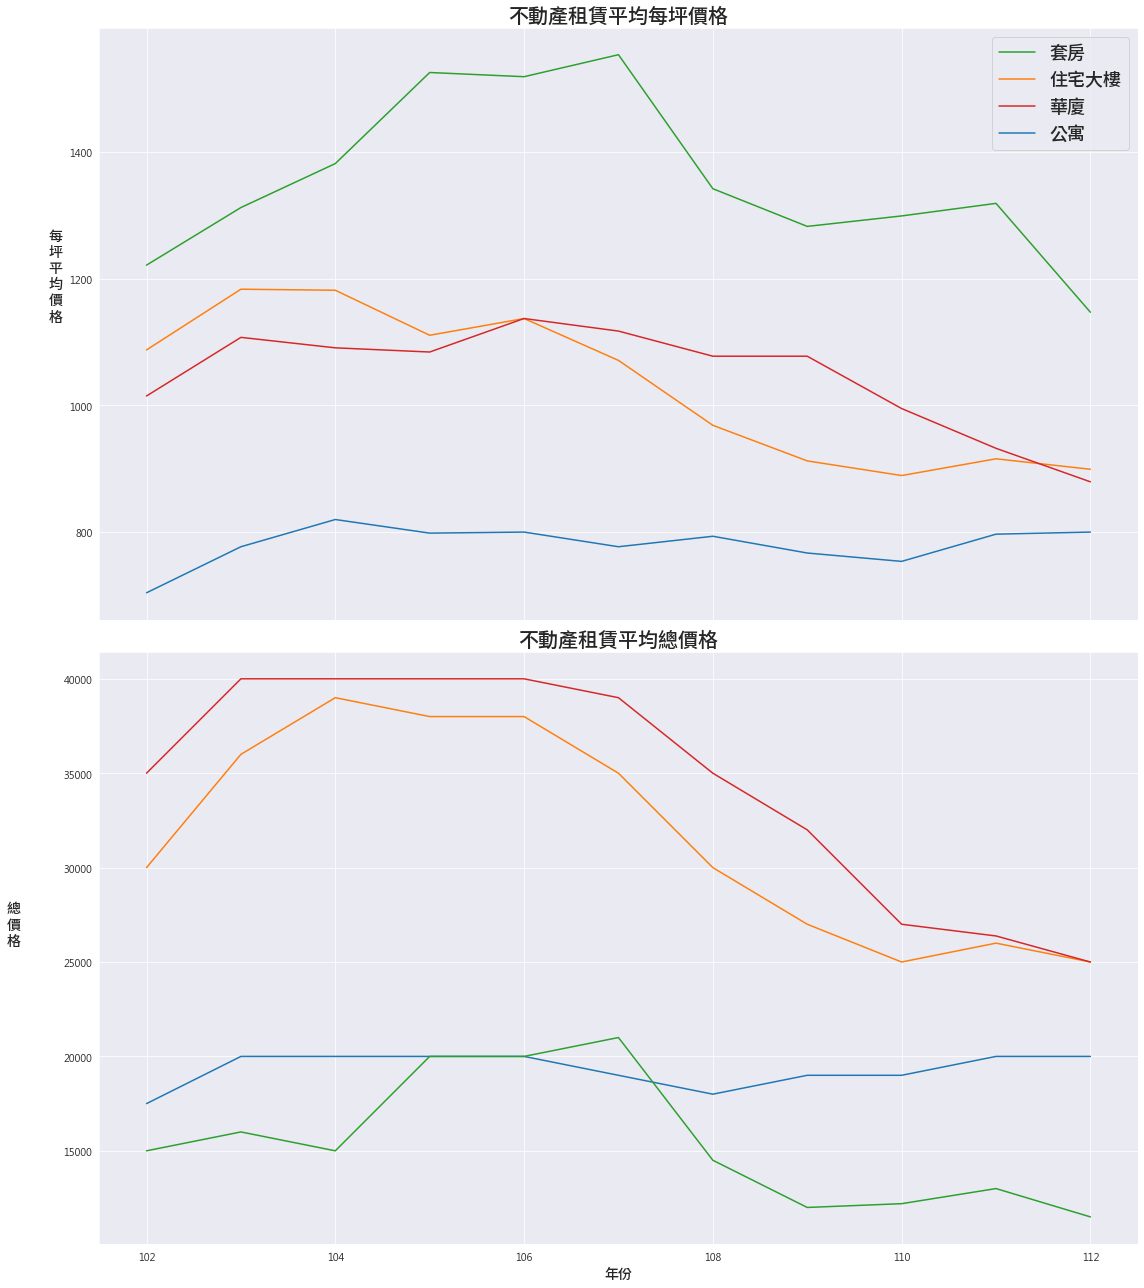

In [7]:
## 3.4不同建物每年租屋價格走勢圖 ##
'''
公寓的漲幅不大，但套房、華廈、住宅大樓有下降的趨勢。
雖然套房每坪價格最高，但考慮到到坪數的加乘，總價反而是最低。
公寓可能由於沒有電梯與管理員，每坪價格與總價皆為次低。
價格大致上可分成三個段位，而華廈與住宅大樓價格沒有太大差別。
租房比起每坪價格，看總價更為適合。
'''
building_type_prices_unit = {}
building_type_prices_all = {}

for building_type in set(df_rental['建物型態2']):
    cond3 = (  (df_rental['主要用途'] == '住家用')
            & (df_rental['建物型態2'] == building_type)
           )
    building_type_prices_unit[building_type] = df_rental[cond3]['單價元坪'].groupby(df_rental[cond3]['年份']).median().loc[102:112]
    building_type_prices_all[building_type] = df_rental[cond3]['總額元'].groupby(df_rental[cond3]['年份']).median().loc[102:112]

price_mean_history_rental_type = pd.DataFrame(building_type_prices_unit)[['公寓', '住宅大樓', '套房', '華廈']]
price_all_history_rental_type = pd.DataFrame(building_type_prices_all)[['公寓', '住宅大樓', '套房', '華廈']]

# 每個建物不同年份不動產租賃價格圖表
fig, axs = plt.subplots(2, 1, figsize = (16, 18), sharex = True)

# 上方子圖 : 每個建物不同年份不動產租賃平均每坪價格
price_mean_history_rental_type.plot(ax = axs[0])
axs[0].set_ylabel('每      \n坪      \n平      \n均      \n價      \n格      ',
                  fontproperties = font_prop, fontsize = 14, rotation = 0)
axs[0].set_title('不動產租賃平均每坪價格', fontproperties = font_prop, fontsize = 20)

# 下方子圖 : 每個建物不同年份不動產租賃總價格
price_all_history_rental_type.plot(ax = axs[1])
axs[1].set_xlabel('年份', fontproperties = font_prop, fontsize = 14)
axs[1].set_ylabel('總      \n價      \n格      ', 
                  fontproperties = font_prop, fontsize = 14, rotation = 0, labelpad = 40)
axs[1].set_title('不動產租賃平均總價格', fontproperties = font_prop, fontsize = 20)

# 取得當前的圖例物件
handles, labels = axs[0].get_legend_handles_labels()

# 按照 sorted_columns 的順序重新排列 handles 和 labels
sorted_columns = price_mean_history_rental_type.loc[112].sort_values(ascending=False).index
handles = [handles[labels.index(column)] for column in sorted_columns]
labels = sorted_columns

# 更新圖例
axs[0].legend(handles, labels, loc = 'upper right', fontsize = 16, prop = font_prop)
axs[1].legend().set_visible(False)
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.tight_layout()

plt.show()

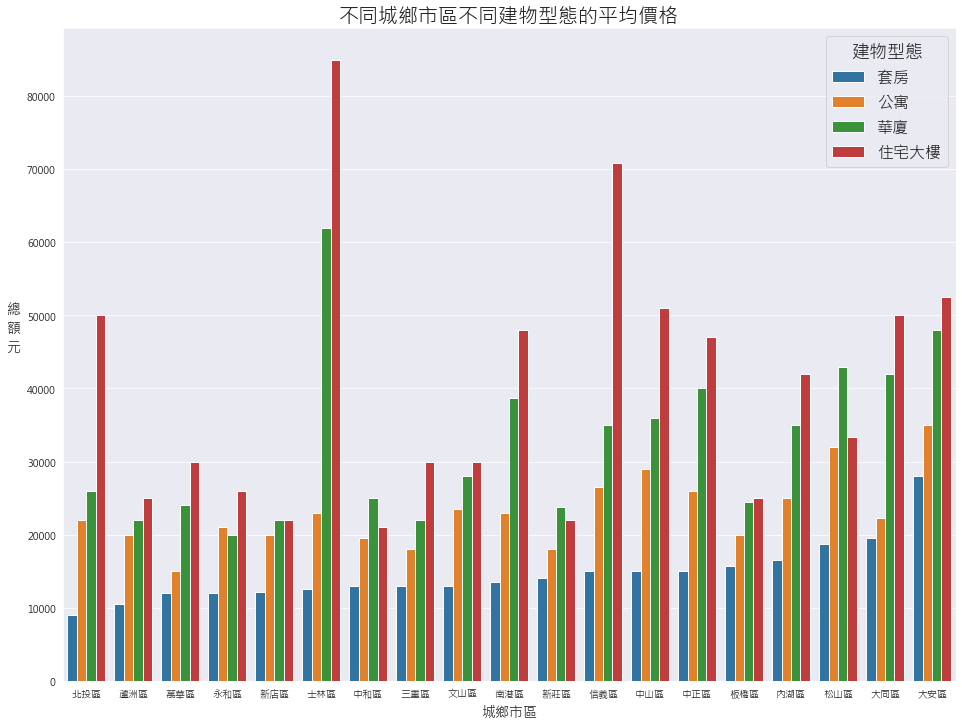

In [8]:
## 3.5不同市區租屋價格分佈圖 ##
'''
在今年公寓、華廈、住宅大樓價位高於套房一截。若是社會新鮮人且個人獨立租房，選擇套房可能較佳，較不容易超過薪水的 30%。
又或者某些地段的公寓或許可以考慮。
'''
plt.figure(figsize=(16, 12))

type={'住宅大樓','華廈','套房','公寓'}
cond4 = (  (df_rental['主要用途'] == '住家用')
        & (df_rental['年份'] == 112)
        & (df_rental['鄉鎮市區'].isin(regions))
        & (df_rental['建物型態2'].isin(type))
       )

# 篩選符合條件的資料
filtered_data = df_rental[cond4]
median_prices = filtered_data.groupby(['鄉鎮市區', '建物型態2'])['總額元'].median().reset_index()
sorted_median_prices = median_prices.sort_values(by = '總額元', ascending = True)

# 使用長條圖呈現價格分布
sns.barplot(x = '鄉鎮市區', y = '總額元', hue = '建物型態2', data = sorted_median_prices, 
            order = sorted_median_prices['鄉鎮市區'].unique())

# 設定圖的標題和標籤
plt.title('不同城鄉市區不同建物型態的平均價格', fontsize = 20)
plt.xlabel('城鄉市區', fontsize = 14)
plt.ylabel('總     \n額     \n元     ', fontsize = 14,rotation = 0)
plt.legend(title = '建物型態', title_fontsize = '18', fontsize = '16', loc = 'upper right')

plt.show()

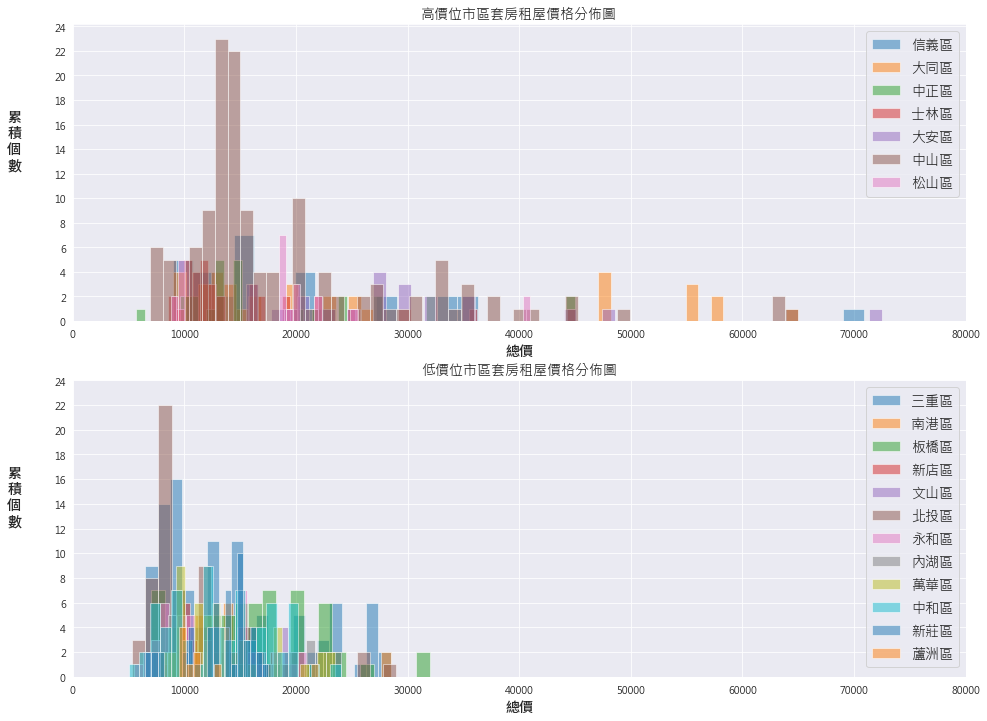

In [9]:
## 3.6不同市區套房租屋價格分佈圖 ##
'''
低價位市區價格只集中在 5,000 ~ 30,000。高價位市區價格雖普遍集中在 5,000 ~ 40,000，但也有一些高於 40,000，甚至超過 70,000。
中山區相比其他高價位區域意外能找得到許多低於 20,000 甚至 10,000 價位的租屋。
'''
fig, axs = plt.subplots(2,1,figsize = (16, 12))

# 價格較高的市區分佈圖
high_price_districts = price_history_rental.loc[112] > 1200
regions_inner = set(price_history_rental.loc[112][high_price_districts].index)

for district in regions_inner:
    cond5 = ( (df_rental['主要用途'] == '住家用')
             & (df_rental['年份'] == 112)
             & (df_rental['建物型態2'] == '套房')
             & (df_rental['鄉鎮市區'] == district)
            )
    dfdistrict = df_rental[cond5]
    dfdistrict['總額元'].hist(ax = axs[0], bins = 50, alpha = 0.5,label = district)
    
axs[0].set_xlabel('總價', fontproperties = font_prop, fontsize = 14)
axs[0].set_ylabel('累\n積\n個\n數', 
                  fontproperties = font_prop, fontsize = 14, rotation = 0, labelpad = 40)
axs[0].set_title('高價位市區套房租屋價格分佈圖', fontsize=14)
axs[0].legend(loc='upper right', fontsize = 14)
axs[0].set_xlim(0, 80000)
axs[0].set_yticks(range(0,25,2))

# 價格較低的市區分佈圖
low_price_districts = price_history_rental.loc[112] < 1200
regions_outer = set(price_history_rental.loc[112][low_price_districts].index)

for district in regions_outer:
    cond5 = ( (df_rental['主要用途'] == '住家用')
             & (df_rental['年份'] == 112)
             & (df_rental['建物型態2'] == '套房')
             & (df_rental['鄉鎮市區'] == district)
            )
    dfdistrict = df_rental[cond5]
    dfdistrict['總額元'].hist(ax = axs[1], bins = 20, alpha = 0.5,label = district)
    
axs[1].set_xlabel('總價', fontproperties = font_prop, fontsize = 14)
axs[1].set_ylabel('累\n積\n個\n數', 
                  fontproperties = font_prop, fontsize = 14, rotation = 0, labelpad = 40)
axs[1].set_title('低價位市區套房租屋價格分佈圖', fontsize = 14)    
axs[1].legend(loc='upper right', fontsize = 14) 
axs[1].set_xlim(0, 80000)
axs[1].set_yticks(range(0,25,2))